# Building a template model of the IC Crab emission

We use here the model of the Crab nebula by Dirson and Horns (2023). It is based on a detailed 3D modeling with spherical symmetry of the electrons distribution in the nebula.

One core assumption is that the magnetic field in the nebula follows a radial dependence with 
$$B(r) = B_0 \left(\frac{r}{r_0} \right)^{-\alpha}$$

In their pulbic data release (https://zenodo.org/records/7319439/files/dieterhorns/crab_pheno-v.1.0-lpha.zip), they provide a table that can be used to build a template model of the IC emission depending on the alpha parameter.

Let's do this below.

In [7]:
##!pip install pooch
#import pooch
from pathlib import Path
from zipfile import ZipFile
import numpy as np
from astropy.io import ascii
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt

In [8]:
# Custom local cache directory
model_folder = Path("./models")
model_folder.mkdir(parents=True, exist_ok=True)


In [9]:
#filename = pooch.retrieve(url="https://zenodo.org/records/7319439/files/dieterhorns/crab_pheno-v.1.0-lpha.zip?download=1", known_hash="md5:05d8a1ec8d8e73c059f2c3665aed193b", path=folder)

In [10]:
#zf = ZipFile(filename)
#zf.extractall()

In [11]:
table = ascii.read("dieterhorns-crab_pheno-33bea59/data_files/ictable.txt")

alphas = [0.0, -0.025, -0.025, -0.05, -0.075, -0.075, -0.1, -0.125, -0.15, -0.175, -0.175, -0.2, -0.225, -0.25, -0.275, -0.275, -0.3, -0.325, -0.35, -0.375, -0.4, -0.425, -0.45, -0.475, -0.5, -0.525, -0.55, -0.575, -0.6, -0.6, -0.625, -0.65, -0.675, -0.7, -0.725, -0.75, -0.775, -0.8, -0.825, -0.825, -0.85, -0.875, -0.875, -0.875, -0.9, -0.925, -0.95, -0.975, -1.0, -1.025, -1.075]

# Restructure table
table["col1"].unit="eV"
table.rename_column("col1", "energy")   

unique_alphas, unique_idx = np.unique(alphas, return_index=True)

# Select only the unique columns
unique_cols = [table.columns[i+1] for i in unique_idx]
cleaned_table = Table(unique_cols, names=unique_alphas, units=["erg/s",]*len(unique_alphas))

cleaned_table["true_energy"] = table["energy"]

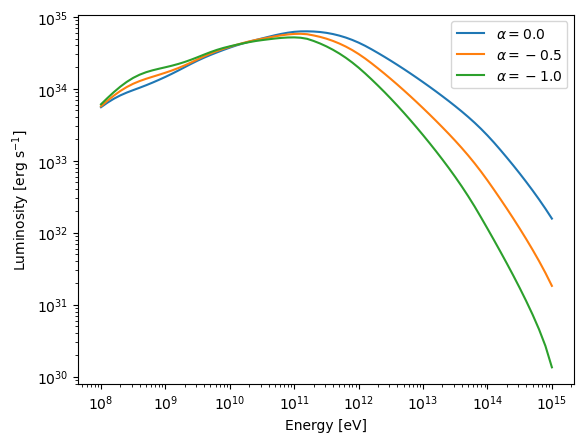

In [12]:
plt.loglog(cleaned_table["true_energy"], cleaned_table["0.0"], label=r"$\alpha=0.0$")
plt.loglog(cleaned_table["true_energy"], cleaned_table["-0.5"], label=r"$\alpha=-0.5$")
plt.loglog(cleaned_table["true_energy"], cleaned_table["-1.0"], label=r"$\alpha=-1.0$")
plt.xlabel("Energy [eV]")
plt.ylabel(r"Luminosity [$\rm erg\ s^{-1}$]")
plt.legend()

In [13]:
from gammapy.modeling.models import TemplateNDSpectralModel
from gammapy.maps import RegionGeom, Map, MapAxis

In [14]:
# Here we create an axis with values at bien centers (i.e. nodes)
energy_true = MapAxis.from_nodes(cleaned_table["true_energy"], name="energy_true", interp="log", unit="eV")

# The alpha parameter axis
alphas = MapAxis.from_nodes(unique_alphas, name="alpha", interp="lin")

In [15]:
# Extract content of the table into a quantity array
data=np.vstack([cleaned_table[str(_)].quantity for _ in unique_alphas])

# Now convert to fluxes
distance = 2*u.kpc

# Finally convert from e2dnde to dnde
data /= 4*np.pi*distance**2
data /= energy_true.center**2

In [16]:
geom = RegionGeom(region=None, axes=[energy_true, alphas])
model_map = Map.from_geom(geom, data=data.to_value("eV-1cm-2s-1"), unit="eV-1cm-2s-1")

In [17]:
model = TemplateNDSpectralModel(model_map, filename=model_folder / "crab_pheno_IC.fits")

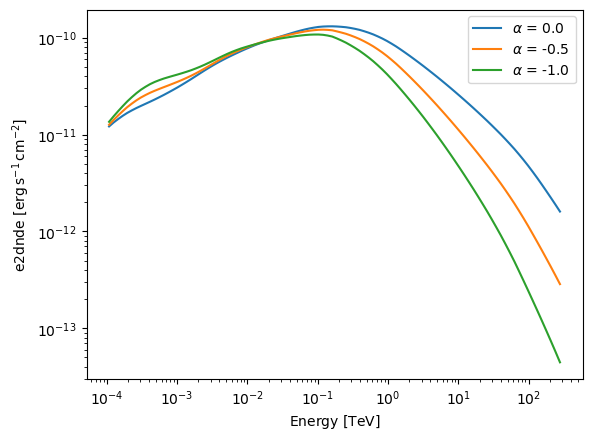

In [18]:
ax=None
for val in [0.0, -0.5, -1.0]:
    model.alpha.value=val
    ax = model.plot(ax=ax, energy_bounds=[0.1*u.GeV, 300*u.TeV], sed_type="e2dnde", label=rf"$\alpha$ = {val}")
ax.legend()

In [19]:
model_map.write(model_folder / "crab_pheno_IC.fits", format="gadf", overwrite=True)

### Adding a dimension to store energy bias

We want to re-use the above table but modify to include a systematic shift of the energy scale caused by instrumental effects. We have to build a `Map` that depends on `alpha` as well an array of `bias` values, typically 50 values from 0.5 to 1.5.

Let's check the Map geometry.

In [21]:
model_map.data.shape

(43, 71, 1, 1)

In [22]:
biases = MapAxis.from_nodes(np.linspace(0.5,1.5,50), unit='', name="bias", interp="lin")
energies = model_map.geom.axes["energy_true"]
alphas = model_map.geom.axes["alpha"]

B, A, E = np.meshgrid(biases.center, alphas.center, energies.center, indexing='ij')

E = E*B

print(E.shape)

(50, 43, 71)


We have now built the array of biased energies `E`. We now need to interpolate over the initial array to determine the correct model value for each bias parameter value.

In [24]:
values = model_map.interp_by_coord({"energy_true":E, "alpha":A})
print(values.shape)

(50, 43, 71)


We can now create the geometry and the Map itself.

In [25]:
# Must put axes in right order
geom = RegionGeom(region=None, axes=[energies, alphas, biases])

bias_model_map = Map.from_geom(geom, data=values, unit=model_map.unit) 

In [26]:
bias_model_map.write("models/biased_crab_pheno_IC.fits", format="gadf", overwrite=True)